#### IMPORTS 

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling, random_ising_model

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from qumcmc.prob_dist import DiscreteProbabilityDistribution, kl_divergence, vectoried_KL, js_divergence
from qumcmc.training import *

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics, PLOT_KL_DIV, PLOT_MAGNETISATION, PLOT_MCMC_STATISTICS, ProcessMCMCData
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
# from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact

from itertools import permutations, product, combinations
import pickle
import os 


#### DATA 

In [2]:
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()
# hebbing learning
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts

### EXPERIMENTS

##### Generate Data

In [3]:
gridsize=3
bas=bas_dataset(grid_size=gridsize)
bas.dataset.sort()

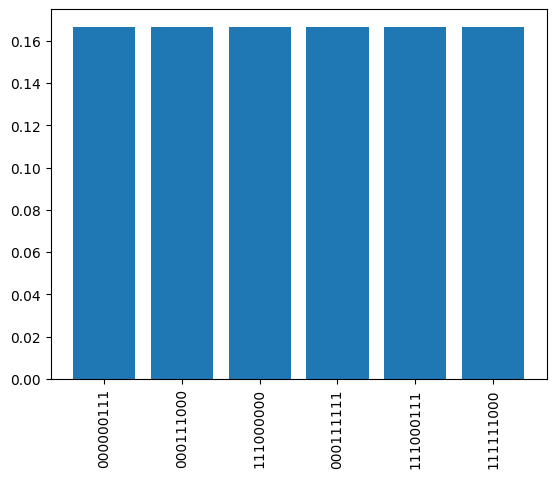

In [4]:
DATA_b3 = DiscreteProbabilityDistribution(Counter( bas.horizontal_bars()  ))

plot_bargraph_desc_order(DATA_b3)

In [5]:
# wt=hebbing_learning(bas.bas_dict['bars'])
# # creating ising model for the bas stripes only dataset
# n_spins=gridsize*gridsize
# shape_of_J=(n_spins,n_spins)
# J=-1*wt
# h=np.zeros(n_spins)
# model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars only')
# #model.model_summary()

##### Prepare parameterized model

     MODEL : param_model |  beta : 1.0
Num Most Probable States : 21
Entropy : 6.266491818450897
---------------------------------------------


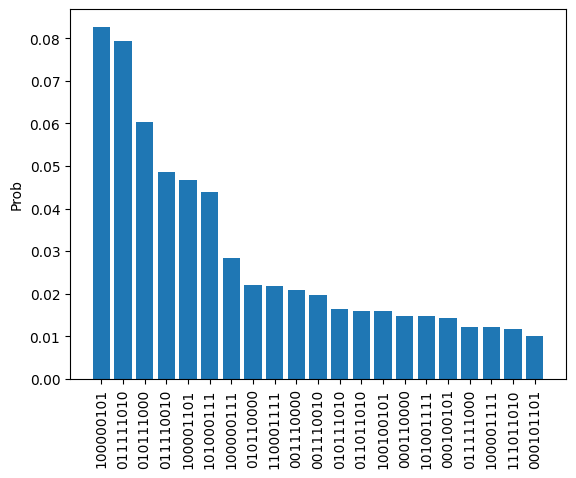

In [6]:
nspin = len(list(DATA_b3.keys())[0])
param_model = random_ising_model(nspin, 9671032, print_model= False)
beta_train = 1.0
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

#### Training 

In [7]:
MCMC_SETTINGS = {
                'qu-wt1': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 1]] , [] ] },
                'qu-wt3':{'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3]] , [] ] },
                'qu-alt-wt1-wt3' : {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3], ['random', 1]] , [0.5, 0.5] ] },
                'qu-stabilizers-wt3': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['custom', [[0,1,2], [3,4,5], [6,7,8]] ]], []] },
                'cl-uniform': {'mcmc_type': 'classical' , 'mixer' : [  [['uniform']], [] ] }, 
                'cl-local-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3]], [] ] },
                'cl-alt-wt1-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3], ['local', 1]], [0.5, 0.5] ] } 
                }

EPOCHS = 400 
MCMC_STEPS = 1000
lr = 0.01



In [8]:
# DATA_E0 = {mcmc_type: cd_training(param_model, beta_train, DATA_b3, name= mcmc_type) for mcmc_type in MCMC_SETTINGS.keys()}

In [9]:
## load experiment ##
name = "TrainingExperiments/BAS3/TRAININGEXPERIMENT_BAS3.pkl"
with open(name, 'rb') as f : DATA_E0 = pickle.load(f)

In [10]:
# name = "TrainingExperiments/BAS3/TRAININGEXPERIMENT_BAS3.pkl"
# for mcmc_type in tqdm(MCMC_SETTINGS.keys()) :
    
#     DATA_E0[mcmc_type].train(lr = lr, mcmc_settings= MCMC_SETTINGS[mcmc_type], epochs= EPOCHS , mcmc_steps= MCMC_STEPS, show_kldiv= True)  ## show_kldiv should be TRUE for training history to be stored
#     with open(name, 'wb') as f:  pickle.dump(DATA_E0, f)


In [53]:
##  save experiment ##
# name = "TrainingExperiments/BAS3/TRAININGEXPERIMENT_BAS3.pkl"
# with open(name, 'rb') as f : DATA_E0 = pickle.load(f)

In [10]:
types_for_plot = ['qu-wt1', 'qu-wt3', 'qu-alt-wt1-wt3', 'qu-stabilizers-wt3', 'cl-uniform' ] ## experiments for other mcmc types were not run yet !

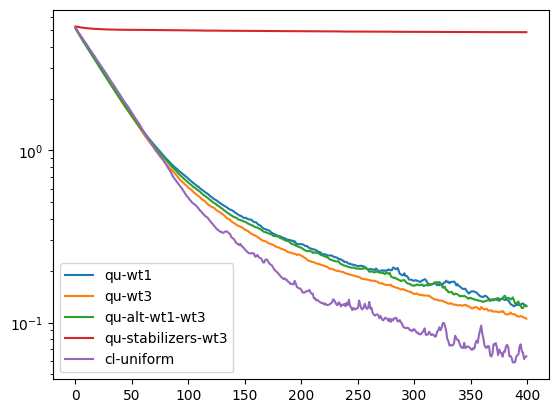

In [12]:
for mcmc_type in types_for_plot:
    plt.plot(DATA_E0[mcmc_type].training_history['kl_div'], label = mcmc_type)
    
plt.yscale('log')
plt.legend()
plt.show()


#### Exact-Sampled  Trained Models 

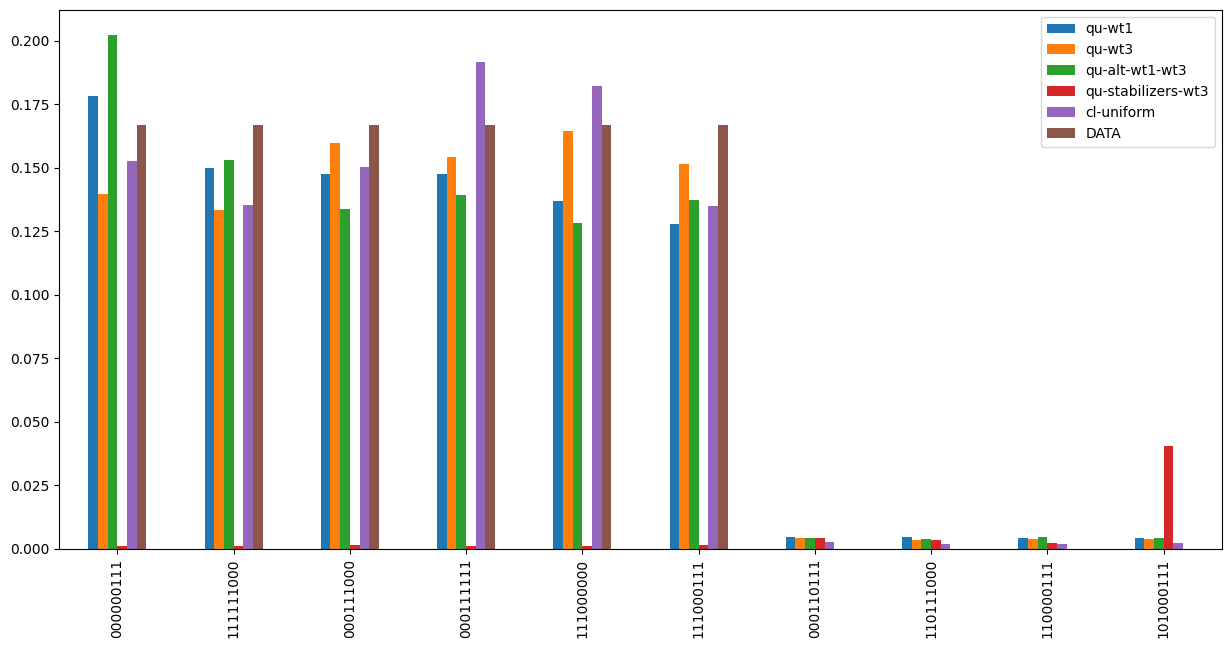

In [13]:
## Exact-Sampled all Trained Models ##
plot_multiple_bargraphs([ Exact_Sampling(DATA_E0[mcmc_type].model, beta_train).boltzmann_pd for mcmc_type in types_for_plot] + [DATA_b3], types_for_plot + ['DATA'], [False]*len(types_for_plot) + [False], plot_first_few= 10)    

#### MCMC Sampled Trained Methods

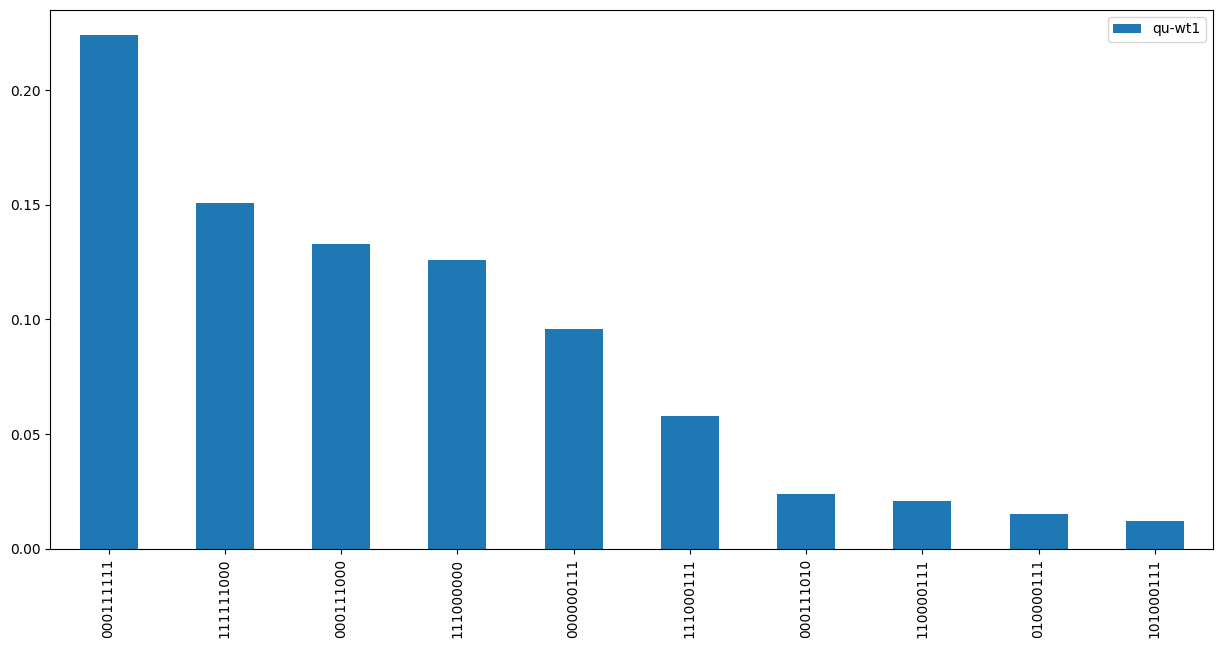

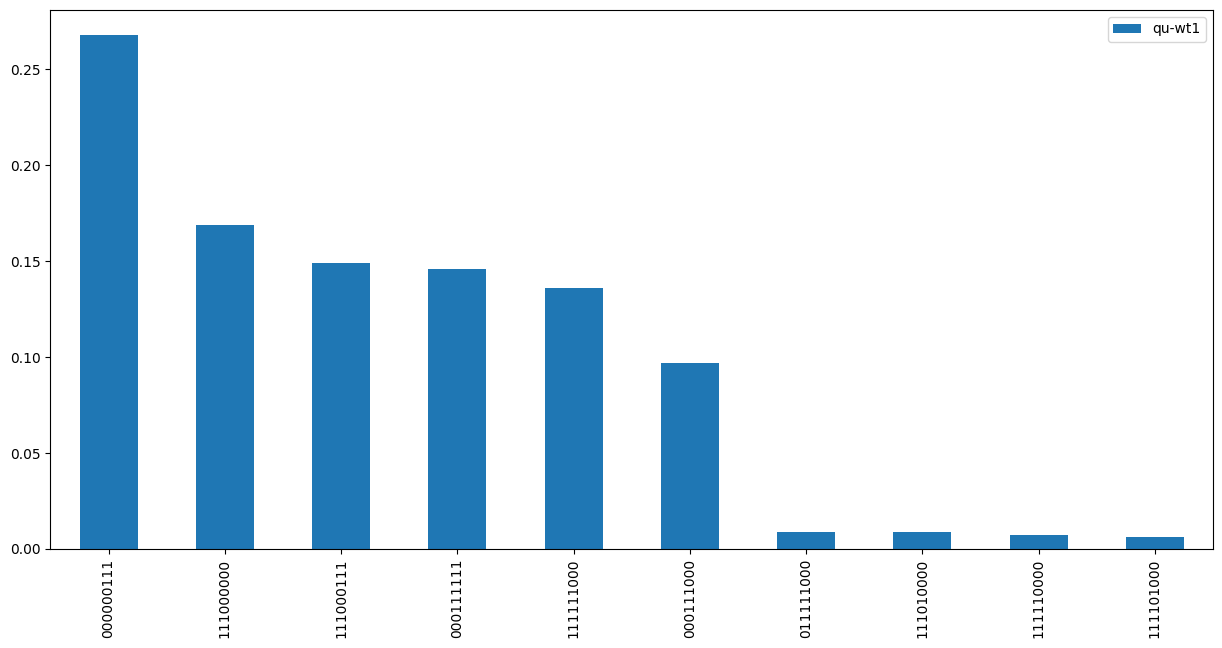

In [14]:
mcmc_type = 'qu-wt1' 
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, initial_state= DATA_b3.get_sample(1)[0] ,mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )

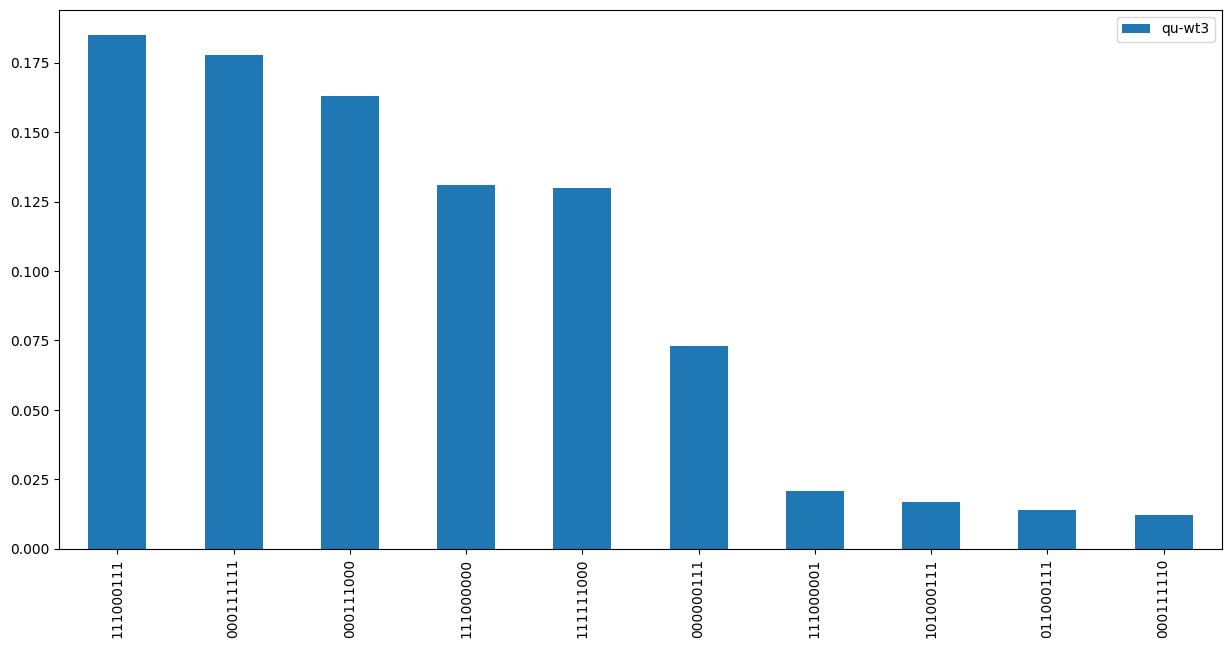

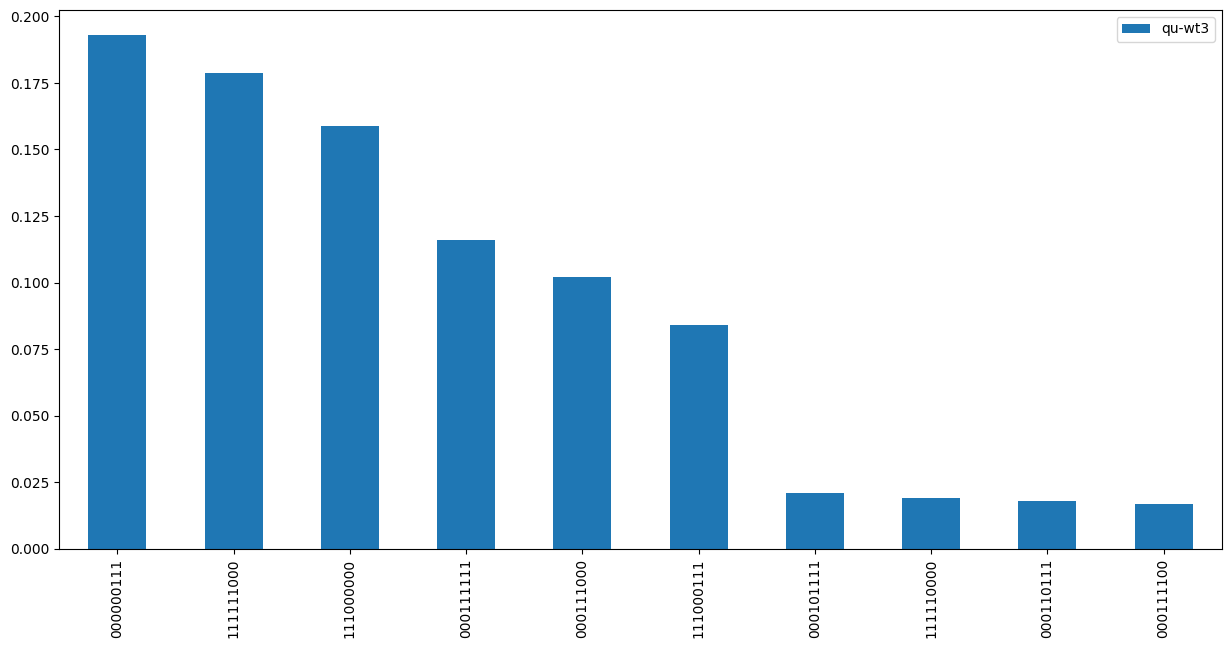

In [15]:
mcmc_type = 'qu-wt3' 
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, initial_state= DATA_b3.get_sample(1)[0] ,mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )

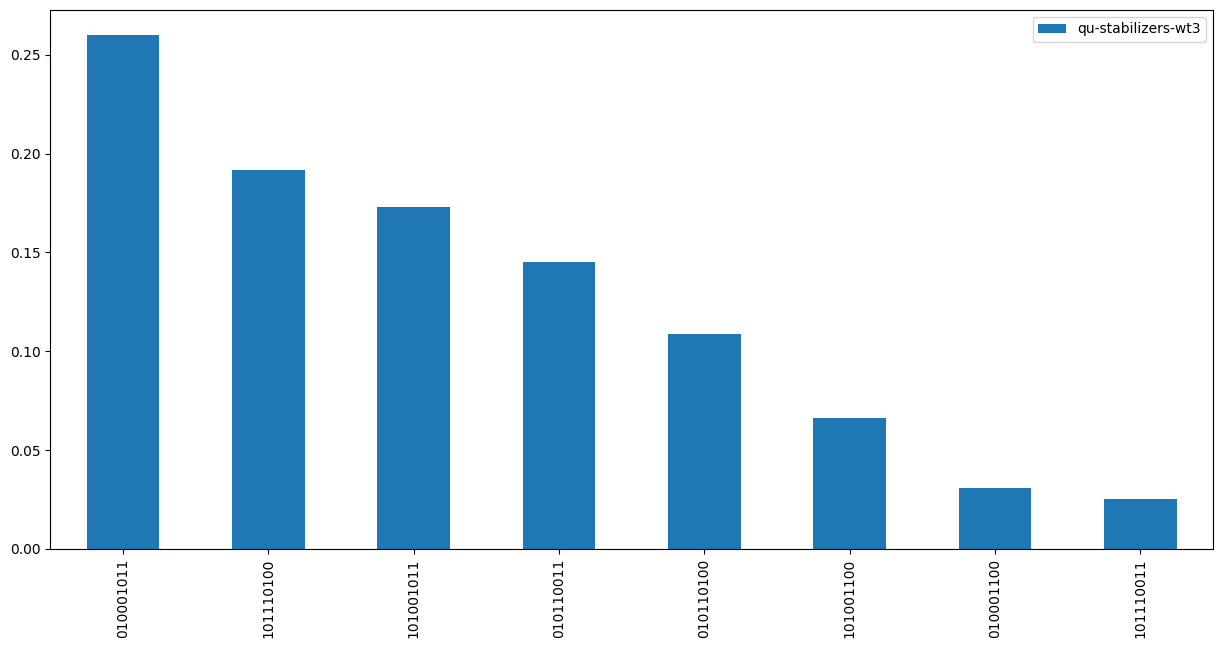

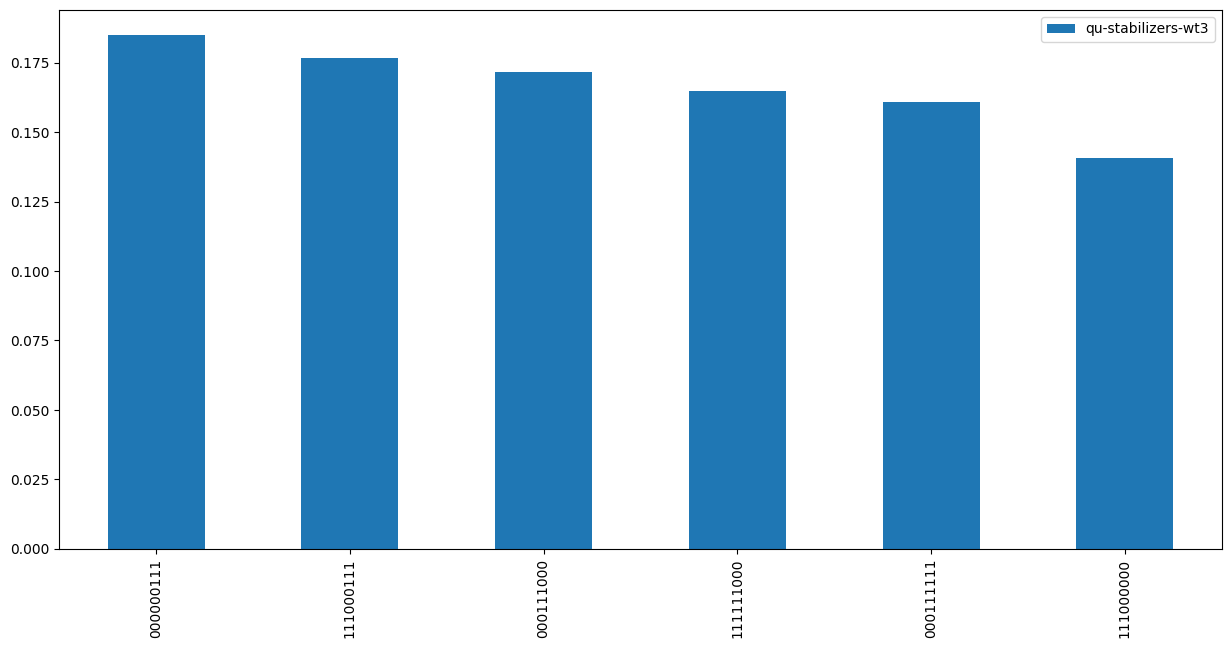

In [16]:
mcmc_type = 'qu-stabilizers-wt3' 
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(quantum_enhanced_mcmc_2(1000, DATA_E0[mcmc_type].model, temperature= beta_train, initial_state= DATA_b3.get_sample(1)[0] ,mixer= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )

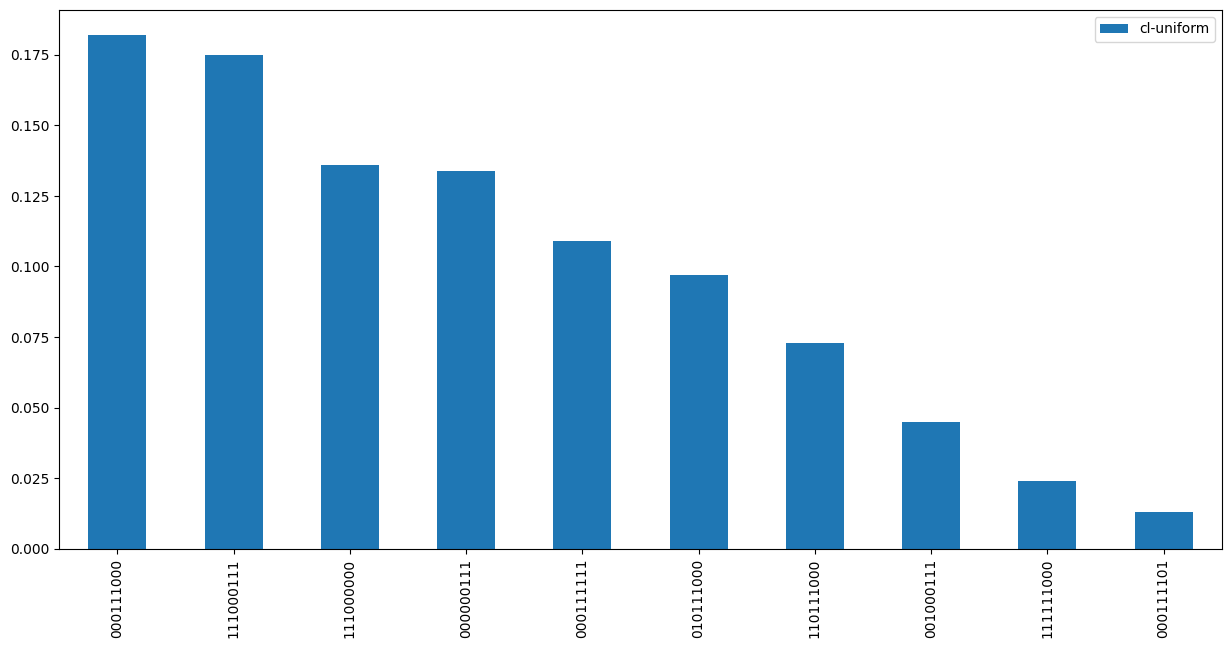

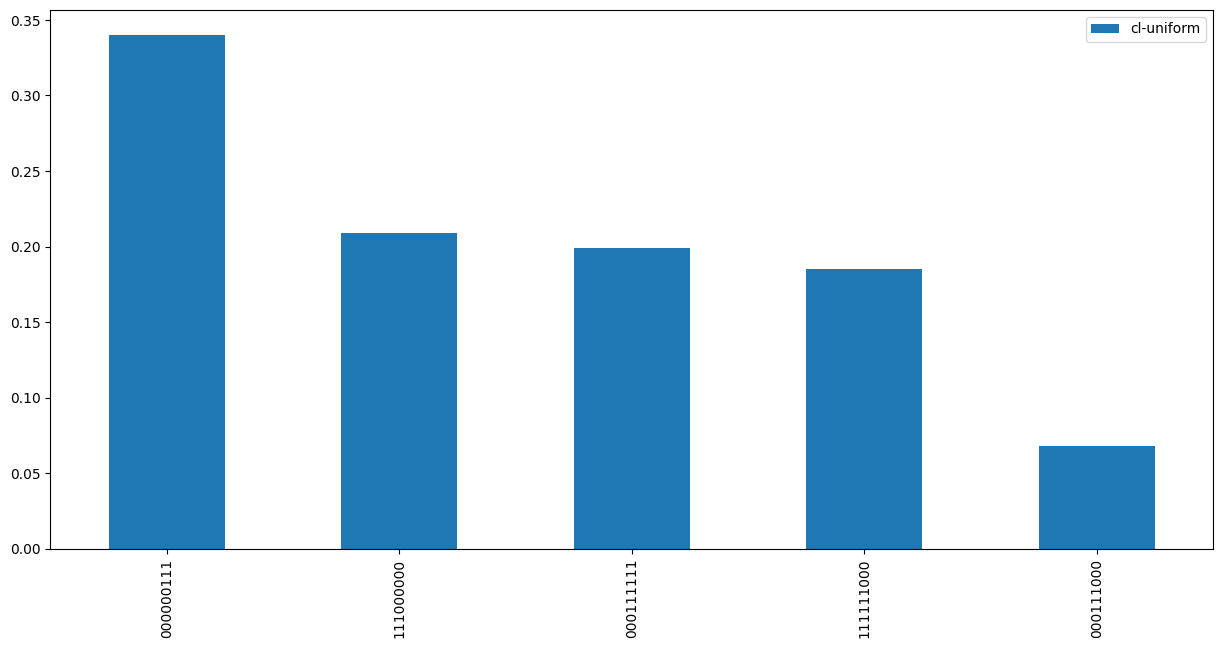

In [17]:
mcmc_type = 'cl-uniform' 
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(classical_mcmc(1000, DATA_E0[mcmc_type].model, temperature= beta_train,proposition_method= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )
plot_multiple_bargraphs( [DiscreteProbabilityDistribution(dict(classical_mcmc(1000, DATA_E0[mcmc_type].model, temperature= beta_train,initial_state= DATA_b3.get_sample(1)[0] , proposition_method= MCMC_SETTINGS[mcmc_type]['mixer']).get_accepted_dict(normalize=True) )).value_sorted_dict(reverse=True) ], [mcmc_type], [False], plot_first_few= 10 )

#### Model Summaries

            MODEL : param_model
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 9 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  0.43263850867222825
Average Bias Strength <|h|>:  0.0699863490848706
alpha :  1.2046990094569645
---------------------------------------------


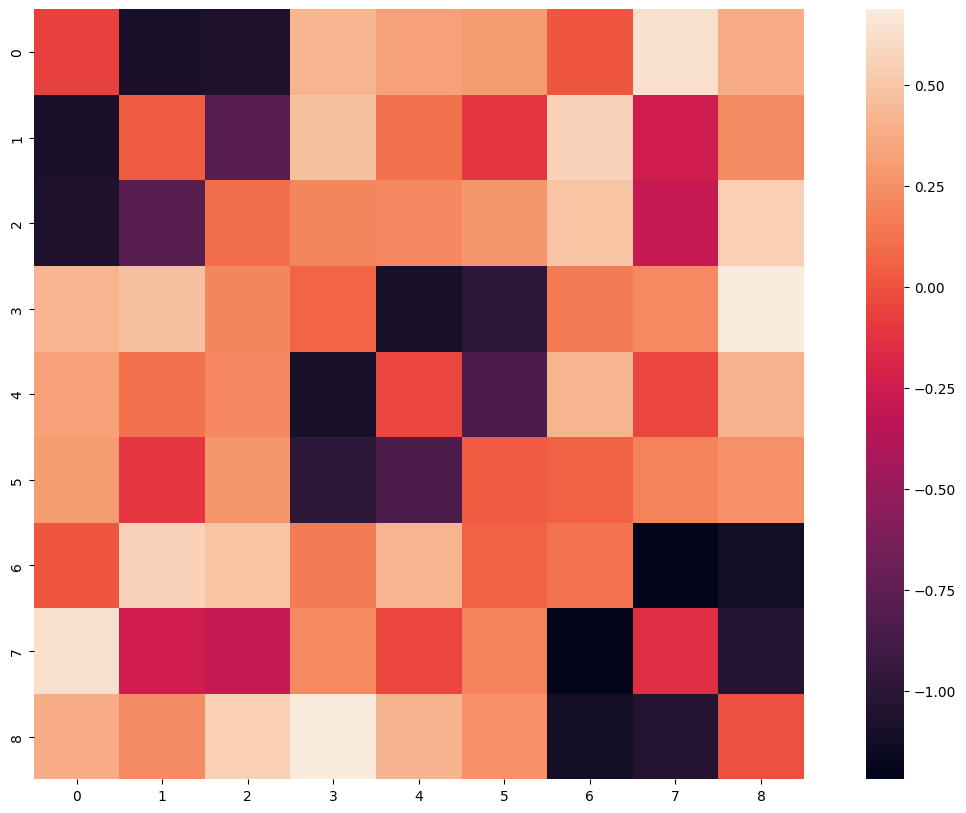

In [18]:
DATA_E0['qu-alt-wt1-wt3'].model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 9 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  0.4431112253907558
Average Bias Strength <|h|>:  0.06380579881385351
alpha :  1.2046990094569645
---------------------------------------------


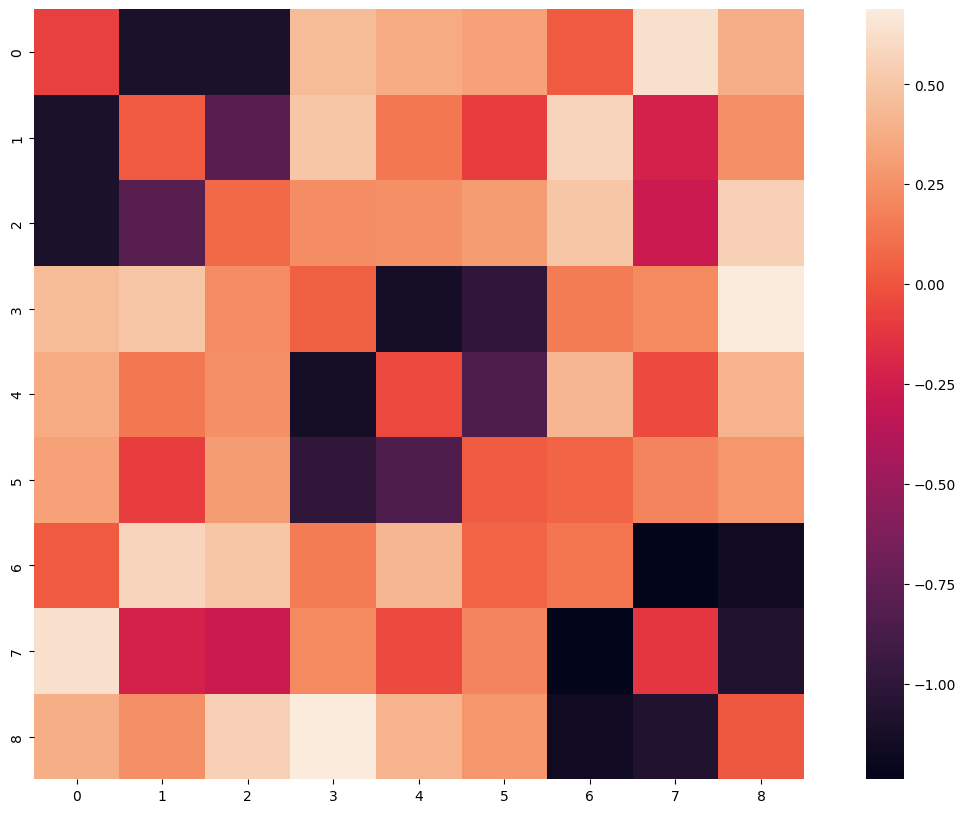

In [19]:
DATA_E0['qu-wt3'].model.model_summary()

            MODEL : param_model
Non-zero Interactions (J) : 36 / 36
Non-zero Bias (h) : 9 / 9
---------------------------------------------
Average Interaction Strength <|J|> :  0.30087744897448054
Average Bias Strength <|h|>:  0.08676668162725078
alpha :  1.2046990094569645
---------------------------------------------


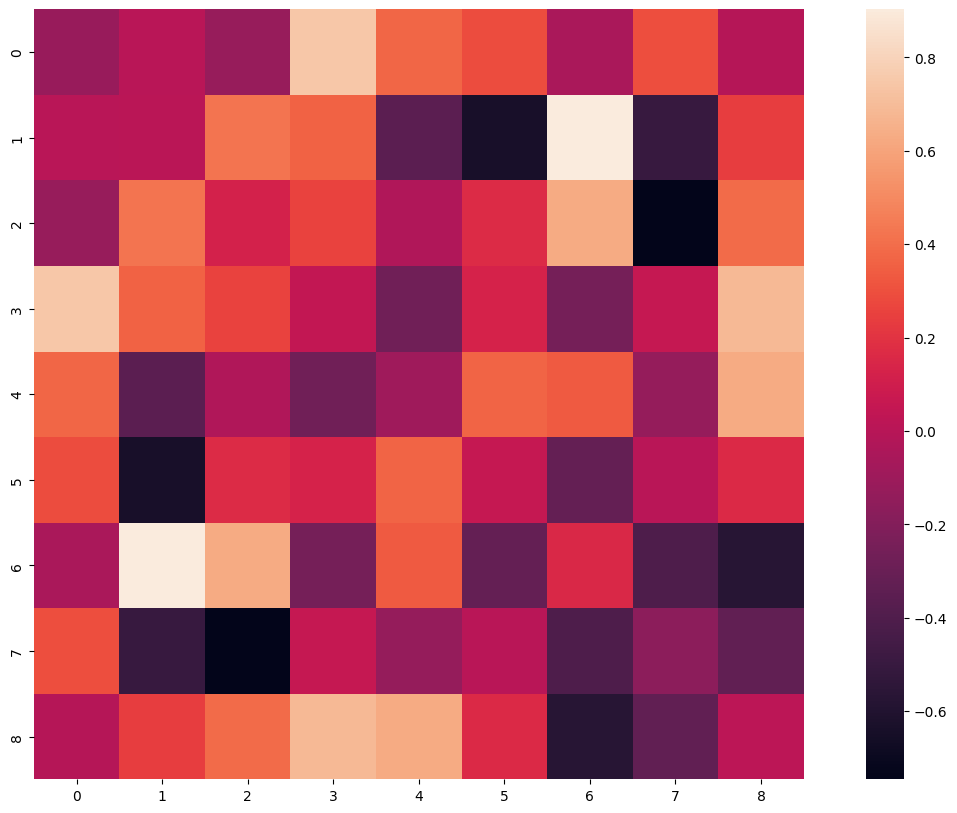

In [20]:
DATA_E0['qu-stabilizers-wt3'].model.model_summary()